In [1]:
import csv
import itertools
import os
import random
import re
import zipfile

from subprocess import check_output

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import skimage as ski
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from numpy import array
from PIL import Image, ImageFilter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import svm
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os

def count_images_in_directory(dir_path):
    # Check if the directory path exists
    if not os.path.exists(dir_path):
        print(f"Directory '{dir_path}' does not exist.")
        return
    
    # Get list of files in the directory
    file_names = os.listdir(dir_path)
    
    # Count the number of image files (assuming common image file extensions like .jpg, .png, etc.)
    image_count = sum(1 for file in file_names if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')))
    
    print(f"There are {image_count} number of images in directory '{dir_path}'.")

# Example usage:
count_images_in_directory(r'C:\Users\DELL\Downloads\test1')
count_images_in_directory(r'C:\Users\DELL\Desktop\train')




There are 12500 number of images in directory 'C:\Users\DELL\Downloads\test1'.
There are 25000 number of images in directory 'C:\Users\DELL\Desktop\train'.


In [7]:
IMAGE_FOLDER_PATH = r'C:\Users\DELL\Desktop\train'
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)

In [8]:
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target
train_cats_dir[:5]

['C:\\Users\\DELL\\Desktop\\train\\cat.0.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\cat.1.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\cat.10.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\cat.100.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\cat.1000.jpg']

In [9]:
train_dogs_dir[:5]

['C:\\Users\\DELL\\Desktop\\train\\dog.0.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\dog.1.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\dog.10.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\dog.100.jpg',
 'C:\\Users\\DELL\\Desktop\\train\\dog.1000.jpg']

In [10]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
target
cat    12500
dog    12500
Name: count, dtype: int64


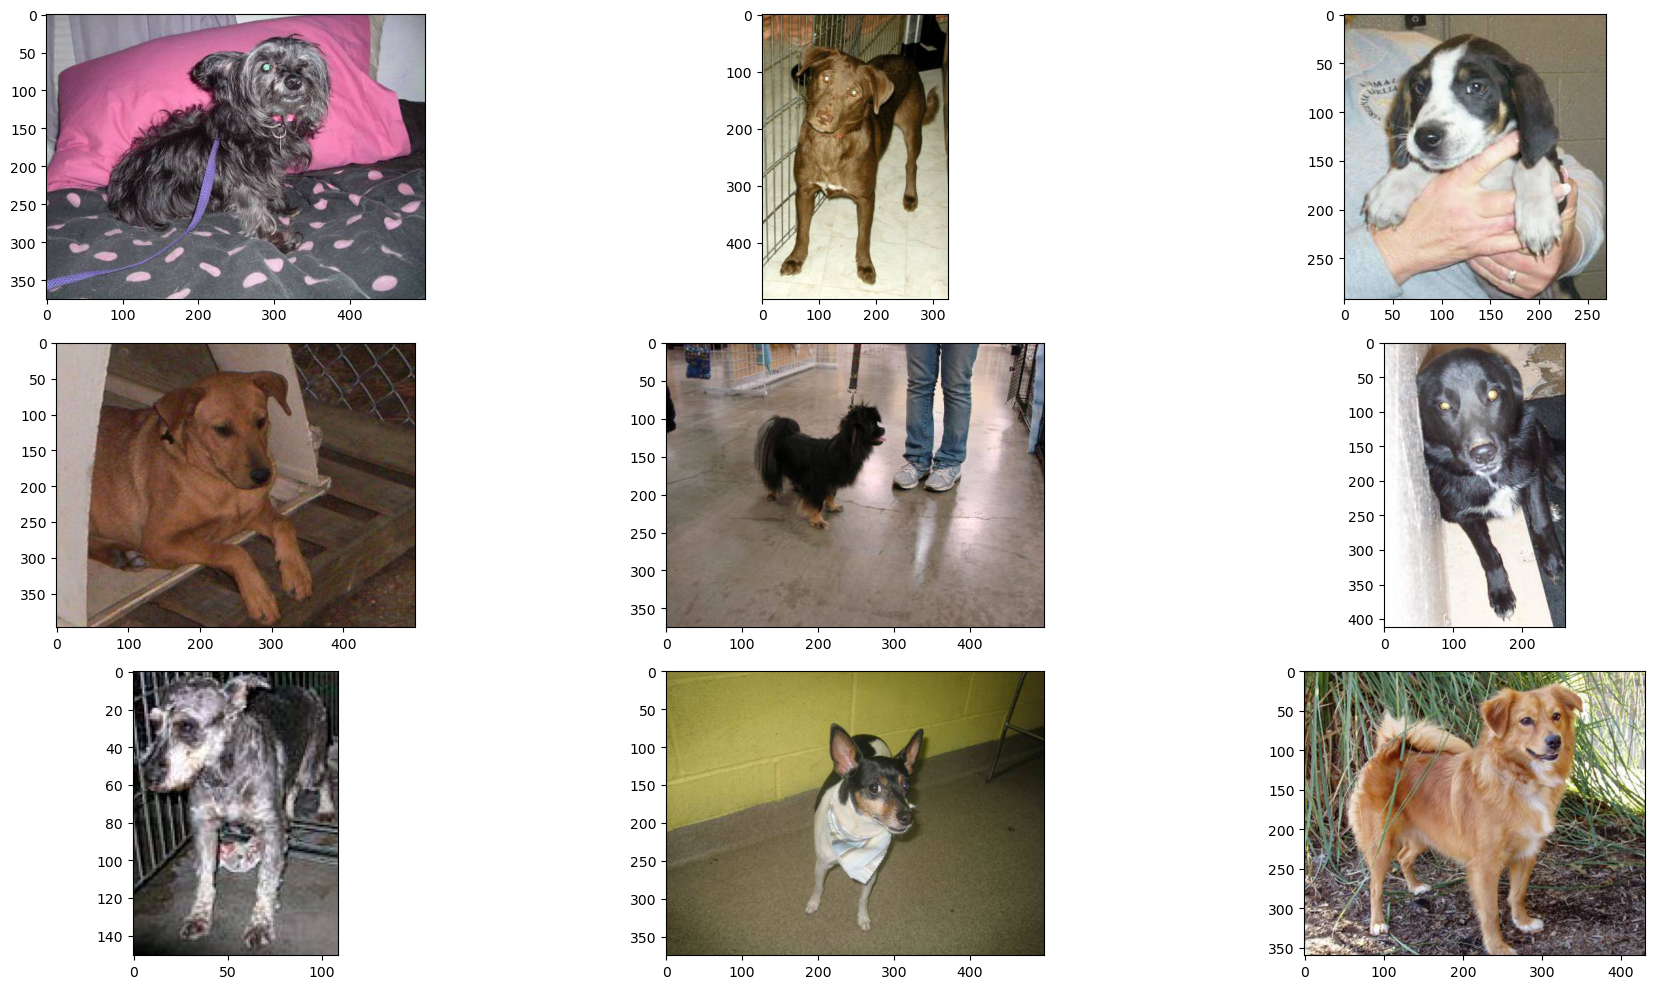

In [13]:
rows = 3
cols = 3
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_dogs_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
    
fig.tight_layout()
plt.show()

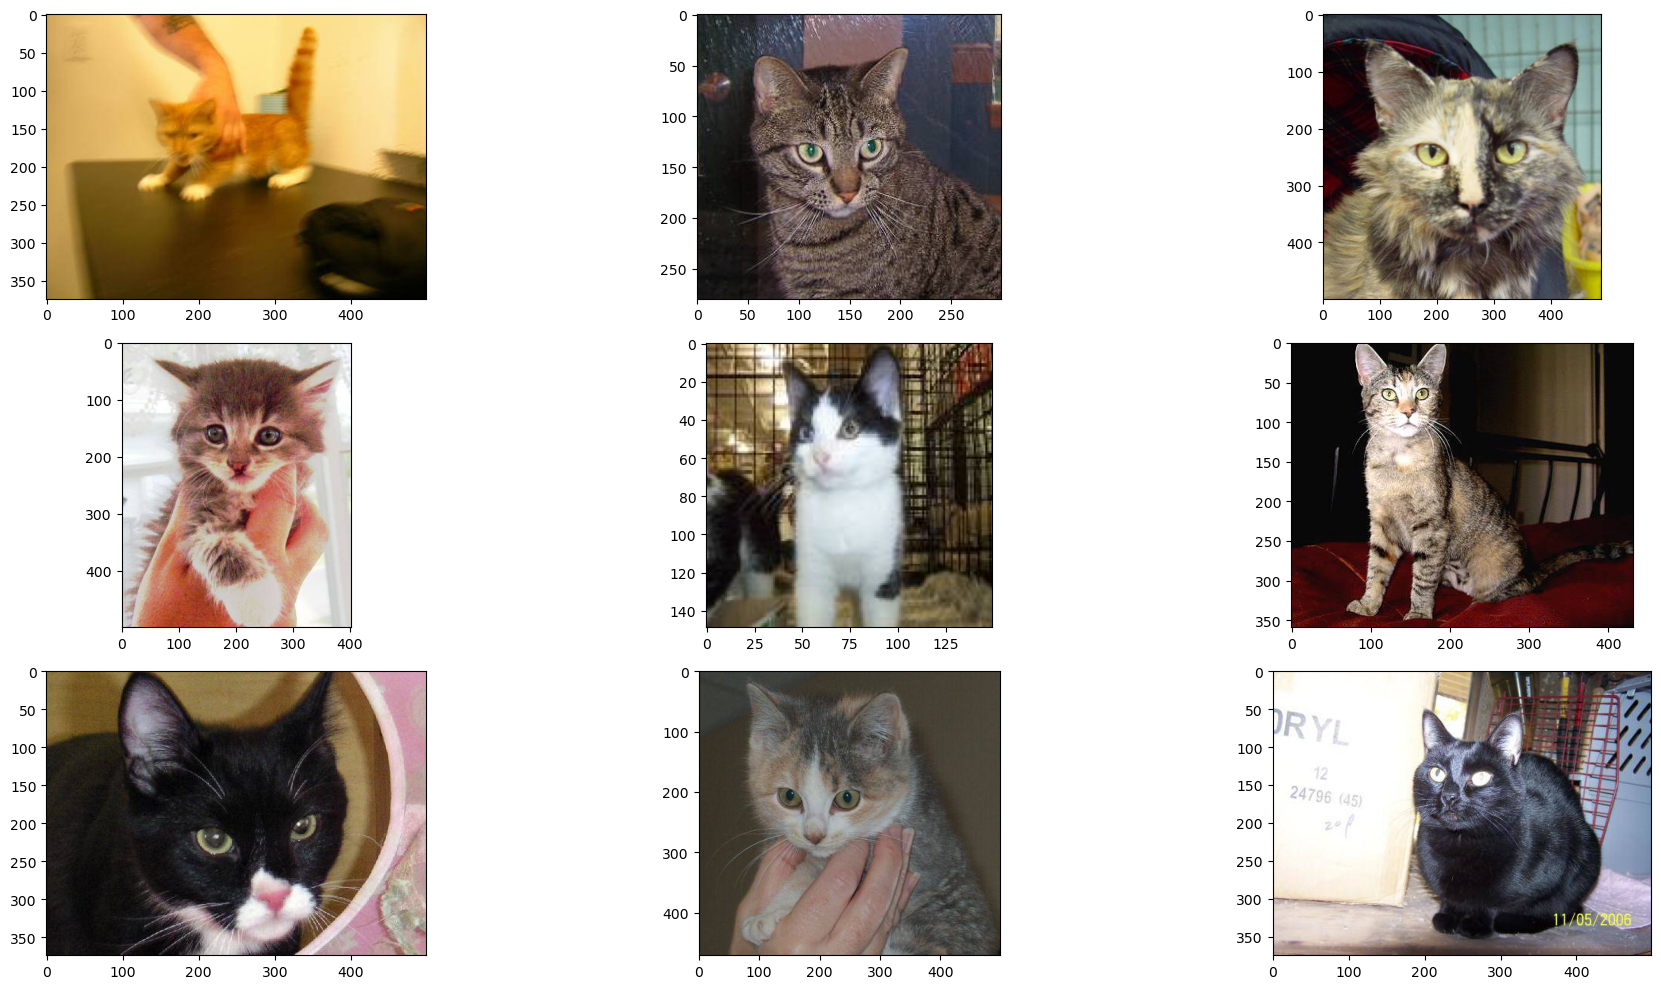

In [12]:
rows = 3
cols = 3
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_cats_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1
    
fig.tight_layout()
plt.show()

In [14]:
train, test_val = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=20)
test, val = train_test_split(test_val, test_size=0.5,  stratify=test_val['target'], random_state=20)

In [15]:
print(dataset['target'].value_counts())
from sklearn.model_selection import train_test_split

train, test_val = train_test_split(dataset, test_size=0.2, random_state=20)
test, val = train_test_split(test_val, test_size=0.5, random_state=20)

target_distribution =test['target'].value_counts()
target_distribution.head(10)

target
cat    12500
dog    12500
Name: count, dtype: int64


target
dog    1257
cat    1243
Name: count, dtype: int64

In [16]:
TEST_DIR = r'C:\Users\DELL\Desktop\TEST'
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [17]:
dataset

image_path target
0         C:\Users\DELL\Desktop\train\cat.0.jpg    cat
1         C:\Users\DELL\Desktop\train\cat.1.jpg    cat
2        C:\Users\DELL\Desktop\train\cat.10.jpg    cat
3       C:\Users\DELL\Desktop\train\cat.100.jpg    cat
4      C:\Users\DELL\Desktop\train\cat.1000.jpg    cat
...                                         ...    ...
24995  C:\Users\DELL\Desktop\train\dog.9995.jpg    dog
24996  C:\Users\DELL\Desktop\train\dog.9996.jpg    dog
24997  C:\Users\DELL\Desktop\train\dog.9997.jpg    dog
24998  C:\Users\DELL\Desktop\train\dog.9998.jpg    dog
24999  C:\Users\DELL\Desktop\train\dog.9999.jpg    dog

[25000 rows x 2 columns]

In [18]:
def preprocess_image(image_path):
    img = imread(image_path)
    # Resize the image to a fixed size
    img = resize(img, (100, 100))
    # Flatten the image to a 1D array
    img_flat = img.flatten()
    return img_flat

X = []
y = dataset['target']
for image_path in dataset['image_path']:
    X.append(preprocess_image(image_path))
X = np.array(X)

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

svm_model = svm.SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()

In [19]:
# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)

# Print accuracy in percentage format
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 65.70%


Classification Report:
              precision    recall  f1-score   support

         cat       0.66      0.65      0.65      2515
         dog       0.65      0.67      0.66      2485

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000

Confusion Matrix:
[[1624  891]
 [ 824 1661]]


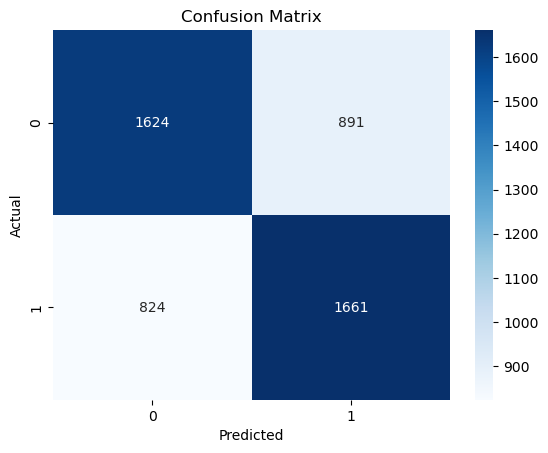

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The predicted label for the image 'C:\Users\DELL\Downloads\test1\8257.jpg' is: cat


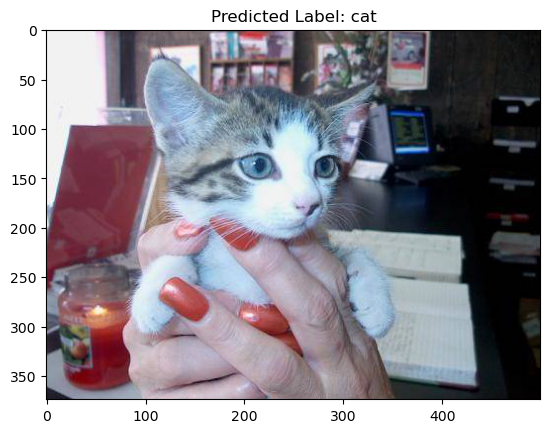

The predicted label for the image 'C:\Users\DELL\Downloads\test1\3606.jpg' is: dog


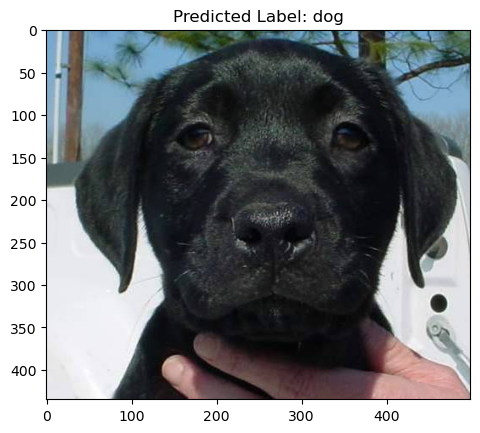

The predicted label for the image 'C:\Users\DELL\Downloads\test1\5136.jpg' is: cat


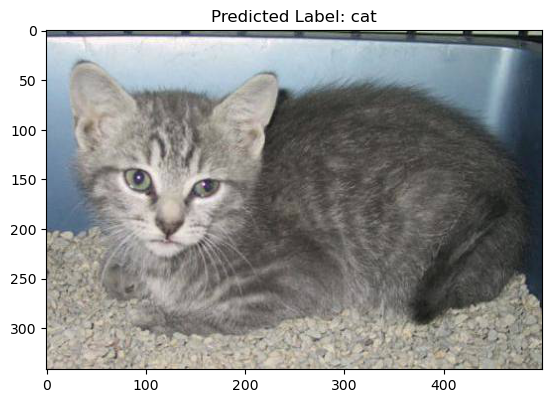

In [30]:
import os
import random
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread
from skimage.transform import resize

# Assume svm_model and pca are already trained and available

def preprocess_image_for_prediction(image_path):
    img = imread(image_path)
    img = resize(img, (100, 100))
    img_flat = img.flatten()
    return img_flat

def predict_image_label(image_path, model, pca):
    img_preprocessed = preprocess_image_for_prediction(image_path)
    img_pca = pca.transform([img_preprocessed])
    prediction = model.predict(img_pca)
    return prediction[0]

# Function to randomly select images from a folder
def get_random_images(folder_path, num_images):
    all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    return random.sample(all_images, num_images)

# Path to the test folder
test_folder_path = r'C:\Users\DELL\Downloads\test1'

# Randomly select 5 images from the test folder
random_image_paths = get_random_images(test_folder_path, 3)

# Loop through the list of images, predict labels, and display images with predicted labels
for image_path in random_image_paths:
    predicted_label = predict_image_label(image_path, svm_model, pca)
    print(f"The predicted label for the image '{image_path}' is: {predicted_label}")
    
    # Display the image with the predicted label
    sample_image = mpimg.imread(image_path)
    plt.imshow(sample_image)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.show()
